In [19]:
# 1. Install dependencies
!pip install lazypredict --quiet

# 2. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt


In [21]:

# 3. Load your data (after you’ve uploaded via the Colab UI)
file_name = 'lung_cancer_data 2.csv'  # make sure this matches the uploaded filename
df = pd.read_csv(file_name)
print(f"✔ Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")
print(df.head())


✔ Loaded lung_cancer_data 2.csv: 23658 rows, 38 columns
    Patient_ID  Age  Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68    Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58    Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44    Male   Former Smoker      67.714305     Lower Lobe   
3  Patient0003   72    Male  Current Smoker      70.806008     Lower Lobe   
4  Patient0004   37  Female    Never Smoked      87.272433     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   
3  Stage III       Chemotherapy               95  African American  ...   
4   Stage IV  Radiation Therapy              105             Asian  ...   

  Alanine_Aminotransferase_Lev

In [22]:

# 4. Data Preprocessing :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
df = df.dropna().reset_index(drop=True)            # drop missing
X = df.iloc[:, :-1]
y_raw = df.iloc[:, -1]


In [23]:

# Encode any categorical X
for col in X.select_dtypes(include=['object','category']):
    X[col] = LabelEncoder().fit_transform(X[col])

# Binarize or encode target
if pd.api.types.is_numeric_dtype(y_raw) and y_raw.nunique() > 2:
    thresh = y_raw.median()
    y = (y_raw > thresh).astype(int)
    print(f"ℹ Target binarized at median = {thresh}")
else:
    y = LabelEncoder().fit_transform(y_raw)


ℹ Target binarized at median = 49.926220387022916


In [24]:

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



--- Summary statistics (scaled) ---
         Patient_ID           Age        Gender  Smoking_History  \
count  2.365800e+04  2.365800e+04  2.365800e+04     2.365800e+04   
mean  -9.610858e-18  2.823189e-17 -1.189344e-16     7.208143e-18   
std    1.000021e+00  1.000021e+00  1.000021e+00     1.000021e+00   
min   -1.731978e+00 -1.697639e+00 -1.008064e+00    -1.227560e+00   
25%   -8.659888e-01 -8.640785e-01 -1.008064e+00    -1.227560e+00   
50%    0.000000e+00 -3.051830e-02  9.920009e-01     1.558608e-03   
75%    8.659888e-01  8.725052e-01  9.920009e-01     1.230677e+00   
max    1.731978e+00  1.706065e+00  9.920009e-01     1.230677e+00   

       Tumor_Size_mm  Tumor_Location         Stage     Treatment  \
count   2.365800e+04    2.365800e+04  2.365800e+04  2.365800e+04   
mean    2.492816e-17   -1.255418e-16 -9.250451e-17  7.268211e-17   
std     1.000021e+00    1.000021e+00  1.000021e+00  1.000021e+00   
min    -1.745108e+00   -1.231292e+00 -1.345669e+00 -1.337900e+00   
25%    -8.

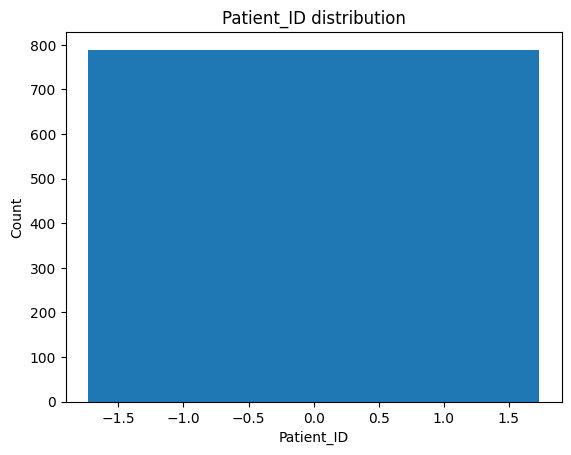

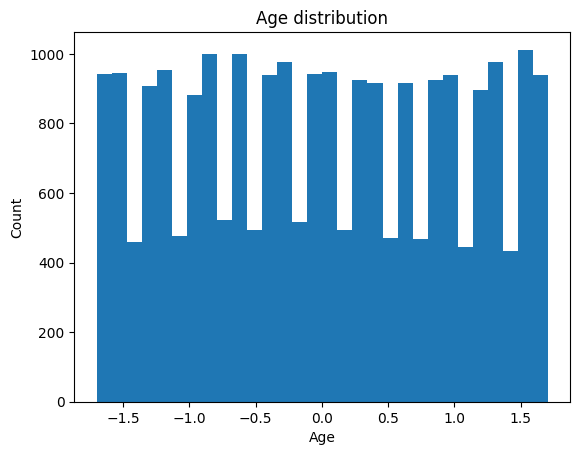

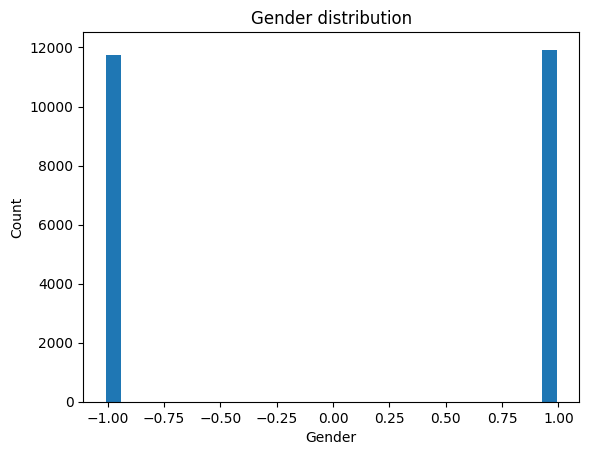

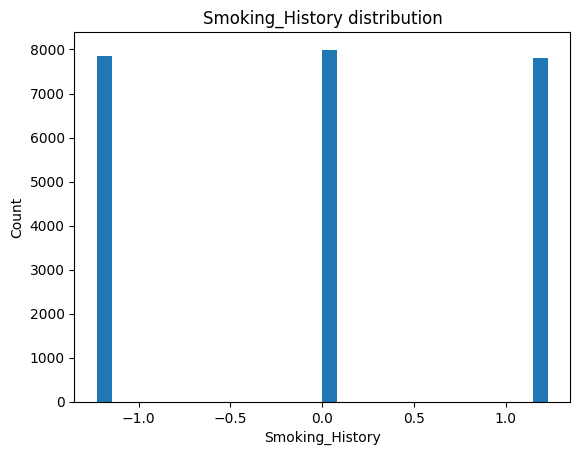

<Figure size 800x600 with 0 Axes>

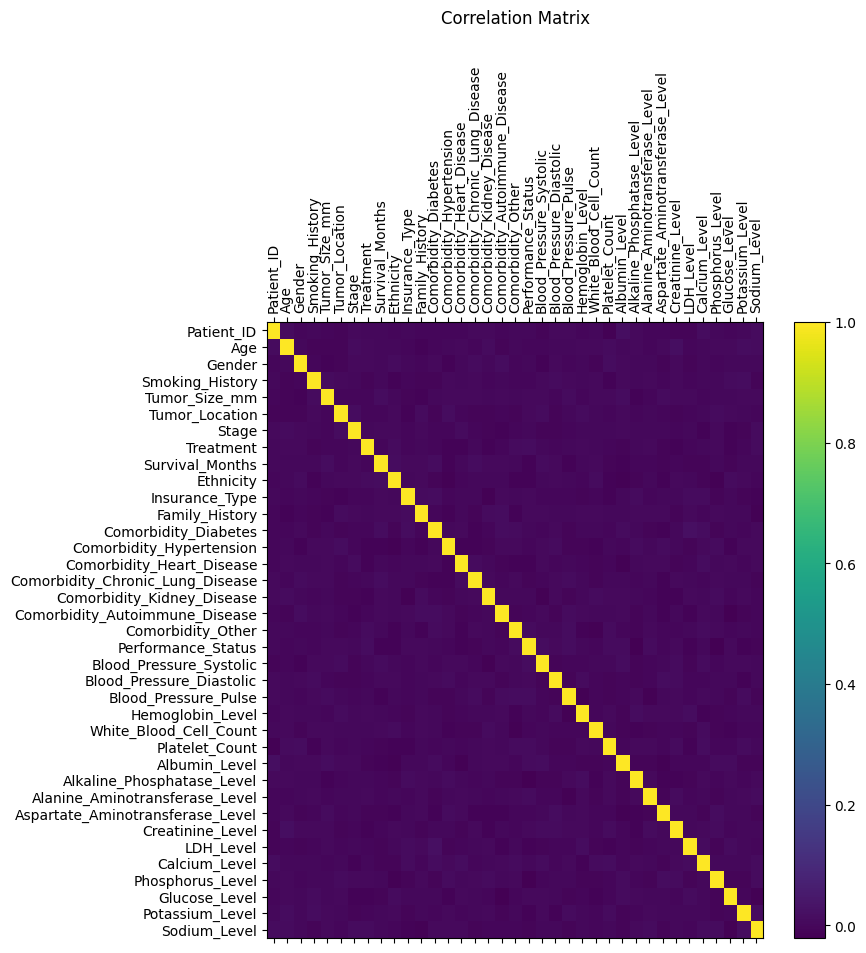

In [28]:
# 5. Exploratory Data Analysis :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}
print("\n--- Summary statistics (scaled) ---")
print(pd.DataFrame(X_scaled, columns=X.columns).describe())

for i, col in enumerate(X.columns[:4]):
    plt.figure()
    plt.hist(X_scaled[:, i], bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

corr = pd.DataFrame(X_scaled, columns=X.columns).corr()
plt.figure(figsize=(8,6))
# Convert the correlation matrix to a NumPy array to avoid ambiguity,
# and then calculate the aspect ratio manually
corr_np = corr.to_numpy()
aspect_ratio = corr_np.shape[0] / corr_np.shape[1]  # rows / columns
# The figaspect function expects a scalar value, not an array
# Calculate the desired figure size based on the aspect ratio
fig_width = 8  # Or any desired width
fig_height = fig_width * aspect_ratio
# Now, create the figure with the calculated dimensions
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
# And then use matshow with the axes object
cax = ax.matshow(corr_np, aspect='auto')  # Use aspect='auto' to fit the matrix
fig.colorbar(cax)
#plt.matshow(corr_np, fignum=1, aspect=aspect_ratio)  # Use aspect parameter
#plt.matshow(corr.to_numpy(), fignum=1)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.yticks(range(len(X.columns)), X.columns)
plt.title("Correlation Matrix", pad=30)
plt.show()

In [29]:

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [30]:

# 7. Modeling & Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (RBF)": SVC(probability=True, random_state=42)
}


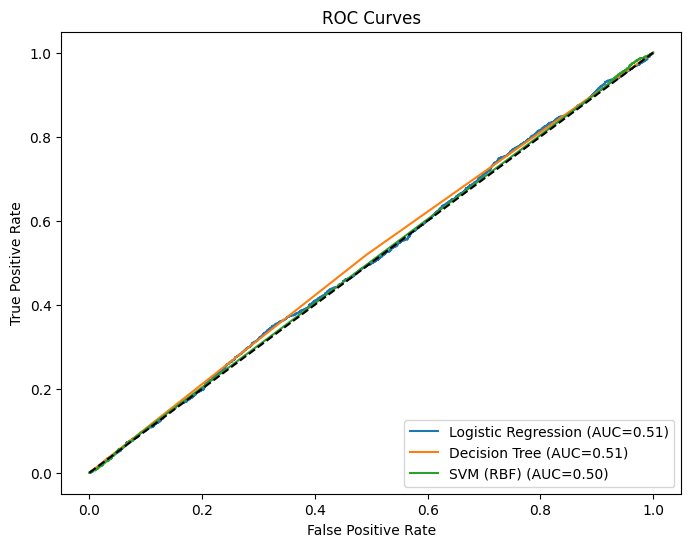

In [31]:

results = []
plt.figure(figsize=(8,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc
    })
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(loc="lower right")
plt.show()


In [32]:

# 8. Results Table
results_df = pd.DataFrame(results).set_index("Model")
print("\n--- Model Performance Comparison ---")
print(results_df)



--- Model Performance Comparison ---
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                                 
Logistic Regression  0.499155   0.499154  0.498732  0.498943  0.506531
Decision Tree        0.513736   0.513604  0.518597  0.516088  0.513736
SVM (RBF)            0.512046   0.511910  0.517751  0.514814  0.503491


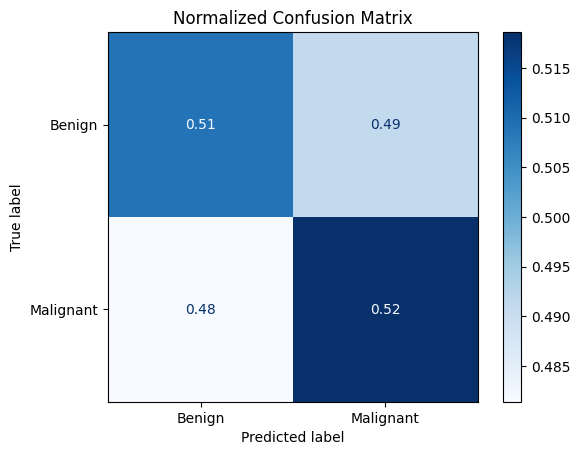

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# Assign the DecisionTreeClassifier to a variable
dtree = DecisionTreeClassifier(random_state=42)

# Fit the model (if it hasn't been fit already)
dtree.fit(X_train, y_train)

best_model = dtree  # Now you can use the 'dtree' variable
disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=["Benign","Malignant"],
    cmap=plt.cm.Blues,
    normalize="true"
)
disp.ax_.set_title("Normalized Confusion Matrix")
plt.show()